# Debug the Calculation of Stroke Error

In [1]:
import os
import xmltodict

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw
from random import randint, seed
from xmlparse import xmlToGeometry

import numpy as np

In [2]:
def loadRef(han_char, ref_dir = "Reference"):
    stroke_list = []
    frac_dists = []
    ref_path = f"{ref_dir}/{han_char[0]}000/{han_char}.han"
    ref_xml = open(ref_path, "r").read()
    root = xmltodict.parse(ref_xml)
    bounds = root["hanDefinition"]["bounds"]
    x_min, y_min, x_max, y_max = (float(bounds["@left"]), float(bounds["@bottom"]), float(bounds["@right"]), float(bounds["@top"]))
    scale = (int(x_max-x_min), int(y_max-y_min))
    strokes = root["hanDefinition"]["strokes"]["stroke"]
    for stroke in strokes:
        points = stroke["points"]["forward"]
        point_arr = []
        frac_arr = []
        for point in points["pointDistance"]:
            point_arr.append((float(point["@x"])-x_min,
                              float(point["@y"])-y_min))
            frac_arr.append(float(point["@fractionalDistance"]))
        stroke_list.append(np.array(point_arr))
        frac_dists.append(np.array(frac_arr))
    return stroke_list, frac_dists, scale

def loadGeometry(data_dir, han_char, output_size = (32, 32), f_read = None):
    """
    Loads geometric data about a gene characetr directly from the XML source
    """
    if f_read is None:
        dir_list = os.listdir(f"{data_dir}/{han_char}")
        dir_list.sort()
    else:
        dir_list = f_read
    g_data = []
    f_names = []
    for f in dir_list:
        flines = open(f"{data_dir}/{han_char}/{f}", "rb").readlines()
        f_names.append(flines[0].decode()[:-1])
    for f in f_names:
        g = xmlToGeometry(f, output_size)
        g_data.append(g)
    return g_data


In [3]:
ref_g, ref_l, output_size = loadRef("5EA6", "Reference")
# in order to test multiple samples, add the file numbers to the f_read list and delete the [0] at the line end
# be aware this will turn g and l into iterables, so handle your loops accordingly
g, l = loadGeometry("HanBitmap", "5EA6", output_size, f_read = ["345"])[0]

In [42]:
def alignStrokes(strokes, ref, p_strokes, p_ref):
    # function to get stroke length given a stroke value (in this case, a stroke value is a 2d list
    # that contains an x coord in stroke[][0] and a y coord in stroke[][1])
    def getStrokeLen(stroke):
        length = 0 # adding all the lengths we get between two points to this variable
        # while it looks a little complicated, this is just the pythagorean theorem applied between two coordinates, just 
        # how one would calculate it on a graph: sqrt(a^2 + b^2)
        for i in range(len(stroke)-1):
            length += ((stroke[i][0] - stroke[i+1][0])**2 + (stroke[i][1] - stroke[i+1][1])**2)**0.5
        return length

    #get the lengths of each stroke for the order in the greedy algorithm
    ref_lengths = []
    for i in range(len(strokes)):
        ref_lengths.append(getStrokeLen(ref[i]))
    print(ref_lengths)
    priority = np.argsort(ref_lengths)[::-1]
    print(priority)
    
    strokes = np.array(strokes)
    p_strokes = np.array(p_strokes)
    ref = np.array(ref)
    p_ref = np.array(p_ref)
    
    error_maps = strokeErrorMatrix(strokes, ref, p_strokes, p_ref)
    
    print(error_maps.astype(int))

    # -1 just means unmatched here since 0 (the other 'default' filler) is a meaningful number in this context
    stroke_map = np.full(len(strokes), -1)

    
    for i in priority:
        largestref = i # this is the index for the reference stroke that is largest
        smallerror = np.argmin(error_maps[largestref, :]) # access the error map from the largest stroke's index and see which error is smallest
        error_maps[:, smallerror] = 10000
        print(error_maps.astype(int))
        stroke_map[smallerror] = largestref # set the index in the stroke_map to the reference stroke we designated

    stroke_map = stroke_map[priority]
    
    return stroke_map

xcolors = ["#7e1e9c", "#15b01a", "#0343df", "#653700", "#e50000", "#f97306", "#033500", "#ffff14", "#001146"]
color_selection = [(int(c[1:3], 16), int(c[3:5], 16), int(c[5:7], 16)) for c in xcolors]
colors = color_selection[:len(ref_l)+1]

def strokeErrorMatrix(strokes, ref, p_strokes, p_ref):
    error_map = np.zeros((len(ref), len(strokes)), dtype=float)
    for i, ref_stroke, r_progresses in zip(range(len(ref)), ref, p_ref):
        for j, candidate_stroke, c_progresses in zip(range(len(strokes)), strokes, p_strokes):
            error_map[i, j] = strokeError(ref_stroke, candidate_stroke, r_progresses, c_progresses)
            print(f"Ref stroke {i} vs Candidate Stroke {j} - error: {error_map[i, j]}")
            img = Image.new(mode="RGBA", size=output_size)
            draw = ImageDraw.Draw(img)
            for a in range(len(ref_stroke)-1):
                x1, y1 = ref_stroke[a]
                x2, y2 = ref_stroke[a+1]
                y1 = -(y1-output_size[1]/2)+output_size[1]/2
                y2 = -(y2-output_size[1]/2)+output_size[1]/2
                draw.line(((x1, y1), (x2, y2)), width=6, fill=colors[0])
            for b in range(len(candidate_stroke)-1):
                x1, y1 = candidate_stroke[b]
                x2, y2 = candidate_stroke[b+1]
                y1 = -(y1-output_size[1]/2)+output_size[1]/2
                y2 = -(y2-output_size[1]/2)+output_size[1]/2
                draw.line(((x1, y1), (x2, y2)), width=6, fill=colors[1])
            display(img)
    return error_map

def strokeError(stroke, ref_stroke, p_stroke, p_ref, mode="max"):
    forward_stroke_error, back_stroke_error = np.zeros(len(ref_stroke)), np.zeros(len(ref_stroke))
    forward_ref_error, back_ref_error = np.zeros(len(stroke)), np.zeros(len(stroke))
    for i, rpoint, rprogress in zip(range(len(ref_stroke)), ref_stroke, p_ref):
        forward_stroke_error[i] = (np.linalg.norm(abs(rpoint-strokeTrace(stroke, p_stroke, rprogress))))
        print(i, rpoint, strokeTrace(stroke, p_stroke, rprogress), forward_stroke_error[i])
    for i, rpoint, rprogress in zip(range(len(ref_stroke)), ref_stroke[::-1], p_ref[::-1]):
        back_stroke_error[i] = (np.linalg.norm(abs(rpoint-strokeTrace(stroke, p_stroke, 1-rprogress))))
    for i, point, progress in zip(range(len(stroke)), stroke, p_stroke):
        forward_ref_error[i] = (np.linalg.norm((point-strokeTrace(ref_stroke, p_ref, progress))))
    for i, point, progress in zip(range(len(stroke)), stroke[::-1], p_stroke[::-1]):
        back_ref_error[i] = (np.linalg.norm((point-strokeTrace(ref_stroke, p_ref, 1-progress))))
    fse_maxdev = forward_stroke_error.argmax()
    bse_maxdev = back_stroke_error.argmax()
    fre_maxdev = forward_ref_error.argmax()
    bre_maxdev = back_ref_error.argmax()
    print(f"{fse_maxdev}, Forward Stroke Error: Comparing points {ref_stroke[i]}, {strokeTrace(stroke, p_stroke, p_ref[i])} with error {forward_stroke_error.max()}")
    print(f"Back Stroke Error: Comparing points {ref_stroke[i]}, {strokeTrace(stroke, p_stroke, 1-p_ref[i])} with error {back_stroke_error.max()}")
    print(f"Forward Reference Error: Comparing points {stroke[i]}, {strokeTrace(ref_stroke, p_ref, p_stroke[i])} with error {forward_ref_error.max()}")
    print(f"Back Reference Error: Comparing points {stroke[i]}, {strokeTrace(ref_stroke, p_ref, 1-p_stroke[i])} with error {back_ref_error.max()}")
    print(f"forward_stroke_error: {forward_stroke_error.max()}, forward_ref_error: {forward_ref_error.max()}")
    print(f"back_stroke_error: {back_stroke_error.max()}, back_ref_error: {back_ref_error.max()}")
    final_error = min(max(forward_stroke_error.max(), back_stroke_error.max()), max(forward_ref_error.max(), back_ref_error.max()))
    return final_error

def strokeTrace(stroke, stroke_progresses, progress):
    if progress == 1:
        return stroke[-1]
    progress_line = len(stroke_progresses)-1
    for i in range(1, len(stroke_progresses)):
        if stroke_progresses[i] > progress:
            progress_line = i-1
            break
    startp, endp = stroke_progresses[progress_line], stroke_progresses[progress_line+1]
    norm_progress = (progress-startp)/endp
    if stroke[progress_line+1][0] == stroke[progress_line][0]:
        x = stroke[progress_line][0]
        y = norm_progress*(stroke[progress_line+1][1]-stroke[progress_line][1])+stroke[progress_line][0]
    else:
        slope = (stroke[progress_line+1][1]-stroke[progress_line][1])/(stroke[progress_line+1][0]-stroke[progress_line][0])
        intercept = stroke[progress_line][1]-slope*stroke[progress_line][0]
        x = norm_progress*(stroke[progress_line+1][0]-stroke[progress_line][0])+stroke[progress_line][0]
        y = slope*x + intercept
    return np.array((x, y))


[50.0, 400.0, 419.19958224894964, 350.0, 120.0, 120.0, 160.0, 635.4029255926852, 352.6375504850911]
[7 2 1 8 3 6 5 4 0]
0 [334.32574249 379.44369761] [250. 250.] 154.48786909365052
1 [334.32574249 341.86867643] [250.         235.50215006] 135.73749953541335
2 [359.70393088 325.75342836] [250.         223.90291358] 149.69462184670144
3 [359.70393088 263.8026917 ] [250. 410.] 182.78021064908174
3, Forward Stroke Error: Comparing points [334.32574249 341.86867643], [250.         235.50215006] with error 182.78021064908174
Back Stroke Error: Comparing points [334.32574249 341.86867643], [250.         214.49784994] with error 152.7552234343938
Forward Reference Error: Comparing points [250. 410.], [359.70393088 263.8026917 ] with error 182.78021064908174
Back Reference Error: Comparing points [250. 410.], [334.32574249 334.32574249] with error 224.78508899655455
forward_stroke_error: 182.78021064908174, forward_ref_error: 182.78021064908174
back_stroke_error: 152.7552234343938, back_ref_err

/tmp/ipykernel_78024/2404120723.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  strokes = np.array(strokes)
/tmp/ipykernel_78024/2404120723.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_strokes = np.array(p_strokes)
/tmp/ipykernel_78024/2404120723.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ref = np.array(ref)

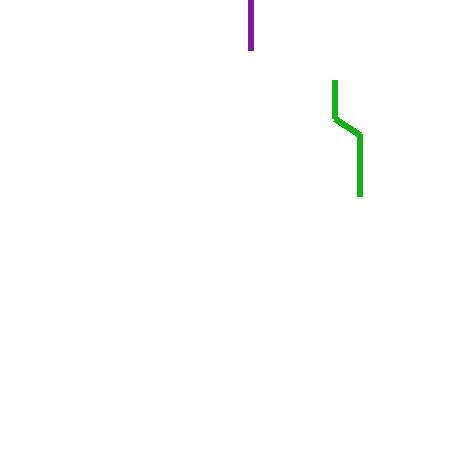

0 [334.32574249 242.34291859] [250. 250.] 84.67267412153343
1 [292.48418349 268.91247087] [250.         232.14529877] 56.18479145801102
2 [233.31128329 268.91247087] [250.         210.82942371] 60.43305082713455
3 [207.9330949 252.7972228] [250. 410.] 162.73394748616792
3, Forward Stroke Error: Comparing points [292.48418349 268.91247087], [250.         232.14529877] with error 162.73394748616792
Back Stroke Error: Comparing points [292.48418349 268.91247087], [250.         217.85470123] with error 187.66919777512396
Forward Reference Error: Comparing points [250. 410.], [207.9330949 252.7972228] with error 233.42115571299897
Back Reference Error: Comparing points [250. 410.], [334.32574249 242.34291859] with error 211.42993020061894
forward_stroke_error: 162.73394748616792, forward_ref_error: 233.42115571299897
back_stroke_error: 187.66919777512396, back_ref_error: 211.42993020061894
Ref stroke 0 vs Candidate Stroke 1 - error: 187.66919777512396


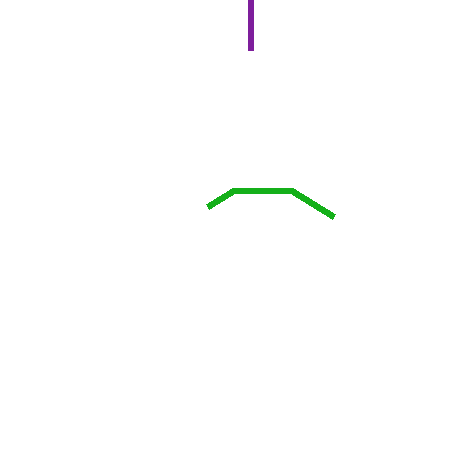

0 [190.6017537  247.13627893] [250. 250.] 59.46723940478981
1 [215.97994208 263.251527  ] [250.         240.58491863] 40.87957284586405
2 [215.97994208 300.82654818] [250.         228.81703743] 79.64128314045367
3 [215.97994208 362.77728484] [250.         209.41508137] 157.09019636950987
4 [241.35813046 378.89253291] [250. 410.] 32.28554502707814
3, Forward Stroke Error: Comparing points [215.97994208 263.251527  ], [250.         240.58491863] with error 157.09019636950987
Back Stroke Error: Comparing points [215.97994208 263.251527  ], [250.         209.41508137] with error 173.3572706978403
Forward Reference Error: Comparing points [250. 410.], [241.35813046 378.89253291] with error 220.99573618168475
Back Reference Error: Comparing points [250. 410.], [190.6017537  247.13627893] with error 173.3572706978403
forward_stroke_error: 157.09019636950987, forward_ref_error: 220.99573618168475
back_stroke_error: 173.3572706978403, back_ref_error: 173.3572706978403
Ref stroke 0 vs Candidate 

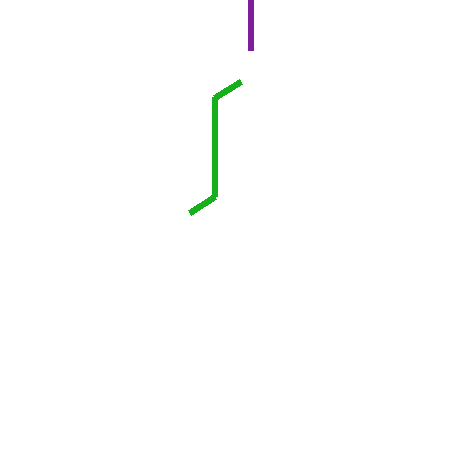

0 [169.17669962 341.86867643] [250. 250.] 122.36118499182349
1 [228.34959983 341.86867643] [250.         237.97141894] 106.12907207903666
2 [253.72778821 357.9839245 ] [250.        231.8603585] 126.1786444132836
3 [312.90068842 357.9839245 ] [250.         219.83177744] 151.7976032110118
4 [410.46030764 357.9839245 ] [250. 410.] 168.68071152224485
4, Forward Stroke Error: Comparing points [228.34959983 341.86867643], [250.         237.97141894] with error 168.68071152224485
Back Stroke Error: Comparing points [228.34959983 341.86867643], [250.         212.02858106] with error 193.41157741908305
Forward Reference Error: Comparing points [250. 410.], [410.46030764 357.9839245 ] with error 168.68071152224485
Back Reference Error: Comparing points [250. 410.], [169.17669962 341.86867643] with error 190.14412951659472
forward_stroke_error: 168.68071152224485, forward_ref_error: 168.68071152224485
back_stroke_error: 193.41157741908305, back_ref_error: 190.14412951659472
Ref stroke 0 vs Candid

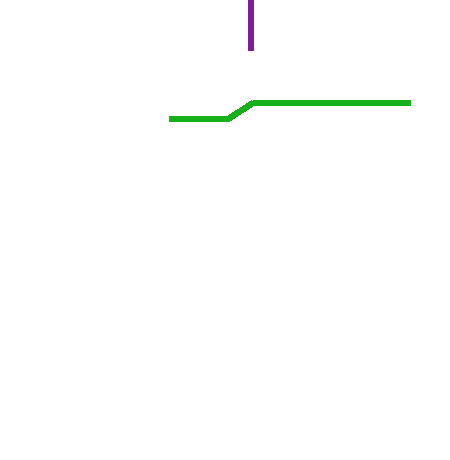

0 [260.54713961 398.30394716] [250. 250.] 148.67852197949728
1 [260.54713961 421.09434955] [250.         234.93561085] 186.45728236130748
2 [285.92532799 437.20959762] [250.         215.06438915] 225.03138189471636
3 [285.92532799 460.        ] [250. 410.] 61.56808581692873
2, Forward Stroke Error: Comparing points [260.54713961 421.09434955], [250.         234.93561085] with error 225.03138189471636
Back Stroke Error: Comparing points [260.54713961 421.09434955], [250.         215.06438915] with error 213.05076669930264
Forward Reference Error: Comparing points [250. 410.], [285.92532799 460.        ] with error 199.73153399778724
Back Reference Error: Comparing points [250. 410.], [260.54713961 260.54713961] with error 149.8245628518159
forward_stroke_error: 225.03138189471636, forward_ref_error: 199.73153399778724
back_stroke_error: 213.05076669930264, back_ref_error: 149.8245628518159
Ref stroke 0 vs Candidate Stroke 4 - error: 199.73153399778724


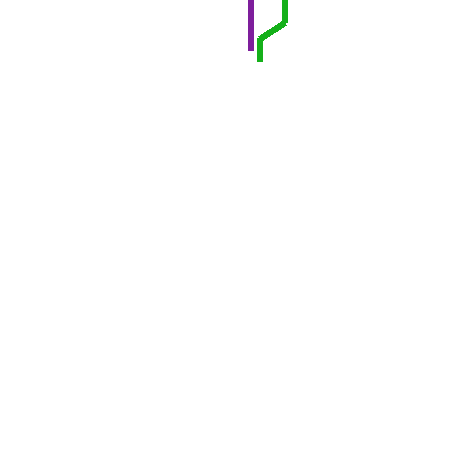

0 [378.52326376 431.84513462] [250. 250.] 222.67887711208425
1 [342.63308556 431.84513462] [250.         243.38266024] 209.99760186569347
2 [317.25489717 415.72988655] [250.        237.8398137] 190.17912401854576
3 [219.69527795 415.72988655] [250.         219.85201928] 198.20826184961342
4 [183.80509975 415.72988655] [250.         213.23467952] 213.04007531383655
5 [147.91492155 415.72988655] [250.         206.61733976] 232.70028033388613
6 [112.02474335 415.72988655] [250. 410.] 138.0941818017103
5, Forward Stroke Error: Comparing points [342.63308556 431.84513462], [250.         243.38266024] with error 232.70028033388613
Back Stroke Error: Comparing points [342.63308556 431.84513462], [250.         206.61733976] with error 243.53325875100901
Forward Reference Error: Comparing points [250. 410.], [112.02474335 415.72988655] with error 138.0941818017103
Back Reference Error: Comparing points [250. 410.], [378.52326376 431.84513462] with error 144.90346577096702
forward_stroke_error: 

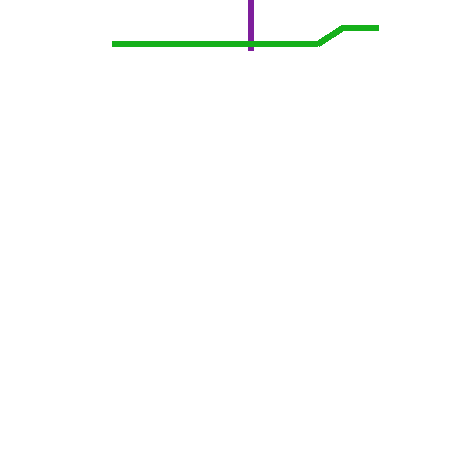

0 [174.89028198 432.85934507] [250. 250.] 197.6841162550215
1 [139.00010378 432.85934507] [250.         246.63345113] 216.79727981401092
2 [139.00010378 395.28432389] [250.         243.10886163] 188.35697034012833
3 [103.10992558 395.28432389] [250.         239.74231275] 213.9392698670343
4 [103.10992558 372.49392151] [250.         237.60454116] 199.42878150702356
5 [103.10992558 310.54318485] [250.         231.79347548] 166.6679653911007
6 [ 61.26836658 283.97363257] [250.         227.14423955] 197.10202780196065
7 [ 61.26836658 246.39861139] [250.         223.61965005] 190.1013164924004
8 [ 61.26836658 184.44787473] [250.         217.80858437] 191.65741936968487
9 [ 25.37818838 184.44787473] [250.        214.4420355] 226.6155509530828
10 [ 25.37818838 122.49713807] [250.         208.63096982] 240.5701461632386
11 [25.37818838 60.54640141] [250.         202.81990414] 265.8885251987665
12 [ 0.         44.43115334] [250. 410.] 442.87761475161545
12, Forward Stroke Error: Comparing point

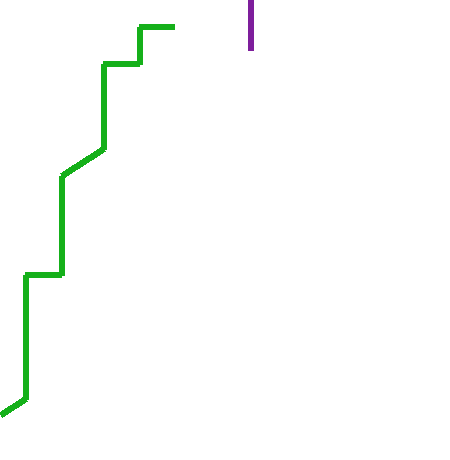

0 [147.4480254   15.41308045] [250. 250.] 256.02330034773104
1 [183.3382036   15.41308045] [250.        247.1048462] 241.0909982121628
2 [183.3382036   38.20348283] [250.         245.26641231] 217.52896787515633
3 [183.3382036   60.99388521] [250.         243.42797842] 194.2318034290462
4 [242.5111038   60.99388521] [250.         238.65467677] 177.81856040000358
5 [267.88929219  77.10913328] [250.         236.22962474] 160.12294518968056
6 [293.26748057  93.22438135] [250.         233.80457271] 147.08795014060837
7 [318.64566895  77.10913328] [250.         231.37952068] 168.85372454845555
8 [318.64566895 139.05986994] [250.         226.38213924] 111.07387893065057
9 [344.02385734 155.17511802] [250.         223.95708721] 116.49654516190898
10 [379.91403554 155.17511802] [250.         221.06193341] 145.66649948614352
11 [344.02385734 155.17511802] [250.         218.16677961] 113.17435742865865
12 [318.64566895 171.29036609] [250.         215.74172758] 81.78111887888728
13 [293.26748057 

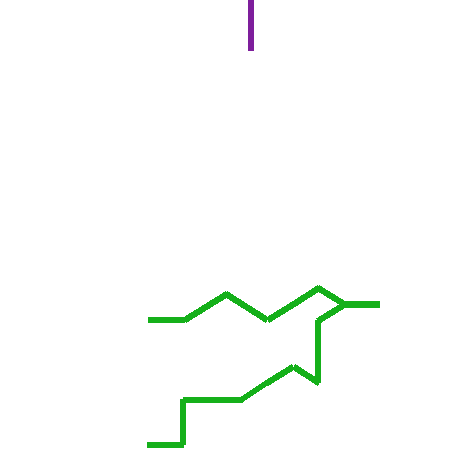

0 [184.60724863 145.73502426] [250. 250.] 123.07476223450712
1 [209.98543701 129.61977619] [250.         245.71237748] 122.79518445628658
2 [209.98543701  92.04475501] [250.         240.35329129] 153.6118067860503
3 [251.82699601  65.47520273] [250.         233.28419683] 167.81893937968218
4 [277.20518439  49.35995466] [250.        228.9965743] 181.68499435842304
5 [313.09536259  49.35995466] [250.         223.87778655] 185.57343136249884
6 [354.93692159  22.79040238] [250.         216.80869209] 220.57845374064223
7 [390.82709979  22.79040238] [250.         211.68990434] 235.61683699127354
8 [450.          22.79040238] [250.         203.25045008] 269.38045366268307
9 [450.   0.] [250. 410.] 456.17978911828175
9, Forward Stroke Error: Comparing points [209.98543701 129.61977619], [250.         245.71237748] with error 456.17978911828175
Back Stroke Error: Comparing points [209.98543701 129.61977619], [250.         204.28762252] with error 320.1562118716424
Forward Reference Error: Compa

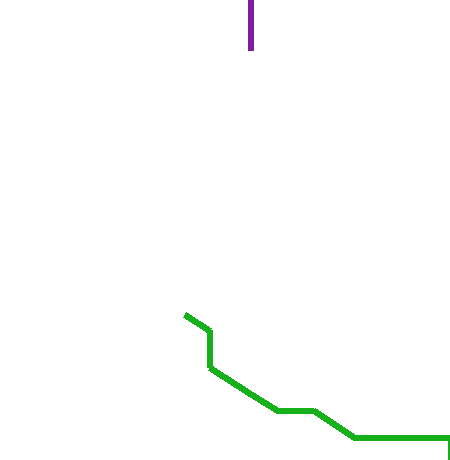

0 [334.32574249 379.44369761] [ 50. 410.] 285.9629616941205
1 [334.32574249 341.86867643] [165.98279956 410.        ] 181.6073337926705
2 [359.70393088 325.75342836] [258.77669133 410.        ] 131.46783833321015
3 [359.70393088 263.8026917 ] [450. 410.] 171.83431861510104
0, Forward Stroke Error: Comparing points [334.32574249 341.86867643], [165.98279956 410.        ] with error 285.9629616941205
Back Stroke Error: Comparing points [334.32574249 341.86867643], [334.01720044 410.        ] with error 342.47653606623817
Forward Reference Error: Comparing points [450. 410.], [359.70393088 263.8026917 ] with error 294.22393018571887
Back Reference Error: Comparing points [450. 410.], [334.32574249 334.32574249] with error 342.47653606623817
forward_stroke_error: 285.9629616941205, forward_ref_error: 294.22393018571887
back_stroke_error: 342.47653606623817, back_ref_error: 342.47653606623817
Ref stroke 1 vs Candidate Stroke 0 - error: 342.47653606623817


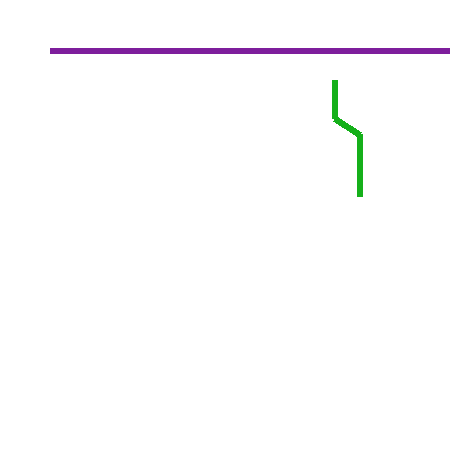

0 [334.32574249 242.34291859] [ 50. 410.] 330.0757864358384
1 [292.48418349 268.91247087] [192.83760982 410.        ] 172.72848786910833
2 [233.31128329 268.91247087] [363.36461028 410.        ] 191.88423264933297
3 [207.9330949 252.7972228] [450. 410.] 288.63315766378753
0, Forward Stroke Error: Comparing points [292.48418349 268.91247087], [192.83760982 410.        ] with error 330.0757864358384
Back Stroke Error: Comparing points [292.48418349 268.91247087], [307.16239018 410.        ] with error 222.83531054546293
Forward Reference Error: Comparing points [450. 410.], [207.9330949 252.7972228] with error 330.0757864358384
Back Reference Error: Comparing points [450. 410.], [334.32574249 242.34291859] with error 222.83531054546293
forward_stroke_error: 330.0757864358384, forward_ref_error: 330.0757864358384
back_stroke_error: 222.83531054546293, back_ref_error: 222.83531054546293
Ref stroke 1 vs Candidate Stroke 1 - error: 330.0757864358384


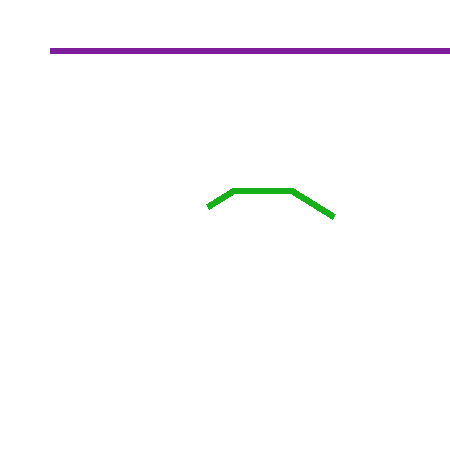

0 [190.6017537  247.13627893] [ 50. 410.] 215.15911503329286
1 [215.97994208 263.251527  ] [125.32065094 410.        ] 172.49411988841345
2 [215.97994208 300.82654818] [219.4637006 410.       ] 109.22902158099305
3 [215.97994208 362.77728484] [374.67934906 410.        ] 165.57622595856097
4 [241.35813046 378.89253291] [450. 410.] 210.94810791503681
0, Forward Stroke Error: Comparing points [215.97994208 263.251527  ], [125.32065094 410.        ] with error 215.15911503329286
Back Stroke Error: Comparing points [215.97994208 263.251527  ], [374.67934906 410.        ] with error 306.28751496869535
Forward Reference Error: Comparing points [450. 410.], [241.35813046 378.89253291] with error 215.15911503329286
Back Reference Error: Comparing points [450. 410.], [190.6017537  247.13627893] with error 306.28751496869535
forward_stroke_error: 215.15911503329286, forward_ref_error: 215.15911503329286
back_stroke_error: 306.28751496869535, back_ref_error: 306.28751496869535
Ref stroke 1 vs Cand

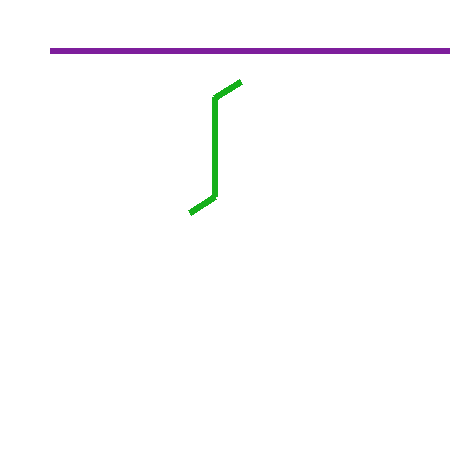

0 [169.17669962 341.86867643] [ 50. 410.] 137.27695722396504
1 [228.34959983 341.86867643] [146.22864845 410.        ] 106.7039263946567
2 [253.72778821 357.9839245 ] [195.11713201 410.        ] 78.36377435345959
3 [312.90068842 357.9839245 ] [291.34578046 410.        ] 56.30529431396666
4 [410.46030764 357.9839245 ] [450. 410.] 65.33803931851715
0, Forward Stroke Error: Comparing points [228.34959983 341.86867643], [146.22864845 410.        ] with error 137.27695722396504
Back Stroke Error: Comparing points [228.34959983 341.86867643], [353.77135155 410.        ] with error 364.1940492338027
Forward Reference Error: Comparing points [450. 410.], [410.46030764 357.9839245 ] with error 137.27695722396504
Back Reference Error: Comparing points [450. 410.], [169.17669962 341.86867643] with error 364.1940492338027
forward_stroke_error: 137.27695722396504, forward_ref_error: 137.27695722396504
back_stroke_error: 364.1940492338027, back_ref_error: 364.1940492338027
Ref stroke 1 vs Candidate 

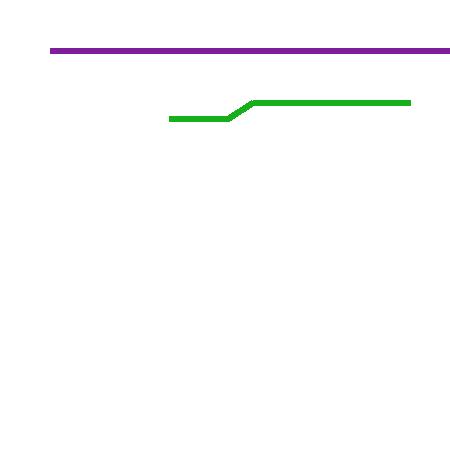

0 [260.54713961 398.30394716] [ 50. 410.] 210.87175166046723
1 [260.54713961 421.09434955] [170.51511317 410.        ] 90.71301105864684
2 [285.92532799 437.20959762] [329.48488683 410.        ] 51.35949151313464
3 [285.92532799 460.        ] [450. 410.] 171.5240449479858
0, Forward Stroke Error: Comparing points [260.54713961 421.09434955], [170.51511317 410.        ] with error 210.87175166046723
Back Stroke Error: Comparing points [260.54713961 421.09434955], [329.48488683 410.        ] with error 241.1654212091832
Forward Reference Error: Comparing points [450. 410.], [285.92532799 460.        ] with error 258.1980934791187
Back Reference Error: Comparing points [450. 410.], [260.54713961 260.54713961] with error 241.30591329518583
forward_stroke_error: 210.87175166046723, forward_ref_error: 258.1980934791187
back_stroke_error: 241.1654212091832, back_ref_error: 241.30591329518583
Ref stroke 1 vs Candidate Stroke 4 - error: 241.1654212091832


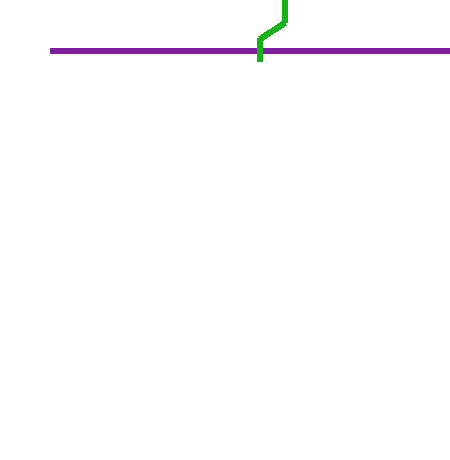

0 [378.52326376 431.84513462] [ 50. 410.] 329.2487581378254
1 [342.63308556 431.84513462] [102.93871808 410.        ] 240.68776393459305
2 [317.25489717 415.72988655] [147.2814904 410.       ] 170.0699579850362
3 [219.69527795 415.72988655] [291.18384577 410.        ] 71.71782852865267
4 [183.80509975 415.72988655] [344.12256385 410.        ] 160.4198269987196
5 [147.91492155 415.72988655] [397.06128192 410.        ] 249.21223984218187
6 [112.02474335 415.72988655] [450. 410.] 338.02382417137306
6, Forward Stroke Error: Comparing points [342.63308556 431.84513462], [102.93871808 410.        ] with error 338.02382417137306
Back Stroke Error: Comparing points [342.63308556 431.84513462], [397.06128192 410.        ] with error 74.74044240417625
Forward Reference Error: Comparing points [450. 410.], [112.02474335 415.72988655] with error 338.02382417137306
Back Reference Error: Comparing points [450. 410.], [378.52326376 431.84513462] with error 74.74044240417625
forward_stroke_error: 338.

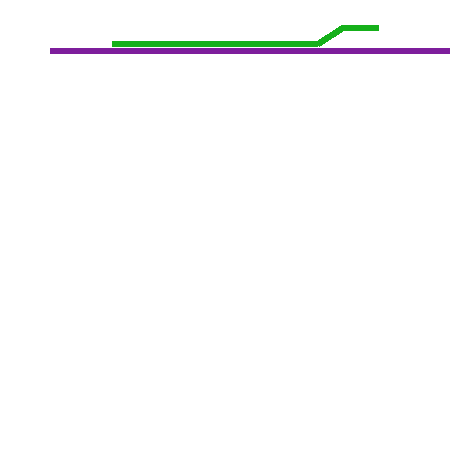

0 [174.89028198 432.85934507] [ 50. 410.] 126.96508256529052
1 [139.00010378 432.85934507] [ 76.93239099 410.        ] 66.14340956276754
2 [139.00010378 395.28432389] [105.12910698 410.        ] 36.92960259150653
3 [103.10992558 395.28432389] [132.06149797 410.        ] 32.47683277402268
4 [103.10992558 372.49392151] [149.16367072 410.        ] 59.39405159897043
5 [103.10992558 310.54318485] [195.65219615 410.        ] 135.85186756785714
6 [ 61.26836658 283.97363257] [232.84608363 410.        ] 212.88860531963934
7 [ 61.26836658 246.39861139] [261.04279963 410.        ] 258.21548840350266
8 [ 61.26836658 184.44787473] [307.53132505 410.        ] 333.94491450766225
9 [ 25.37818838 184.44787473] [334.46371604 410.        ] 382.6324928942798
10 [ 25.37818838 122.49713807] [380.95224146 410.        ] 457.26447799970845
11 [25.37818838 60.54640141] [427.44076689 410.        ] 532.7026699765416
12 [ 0.         44.43115334] [450. 410.] 579.7763203581881
12, Forward Stroke Error: Comparing poi

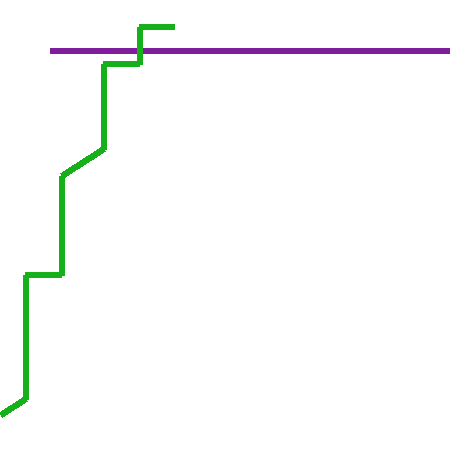

0 [147.4480254   15.41308045] [ 50. 410.] 406.44182208104587
1 [183.3382036   15.41308045] [ 73.16123038 410.        ] 409.6801221800993
2 [183.3382036   38.20348283] [ 87.86870152 410.        ] 383.8581456820703
3 [183.3382036   60.99388521] [102.57617266 410.        ] 358.2286613319805
4 [242.5111038   60.99388521] [140.76258585 410.        ] 363.53545778235144
5 [267.88929219  77.10913328] [160.16300209 410.        ] 349.88752867543116
6 [293.26748057  93.22438135] [179.56341832 410.        ] 336.564119211589
7 [318.64566895  77.10913328] [198.96383456 410.        ] 353.7514249137559
8 [318.64566895 139.05986994] [238.9428861 410.       ] 282.4200553600008
9 [344.02385734 155.17511802] [258.34330233 410.        ] 268.84359390605124
10 [379.91403554 155.17511802] [281.50453272 410.        ] 273.1668917056344
11 [344.02385734 155.17511802] [304.6657631 410.       ] 257.84642727931305
12 [318.64566895 171.29036609] [324.06617933 410.        ] 238.77116923133562
13 [293.26748057 155.175

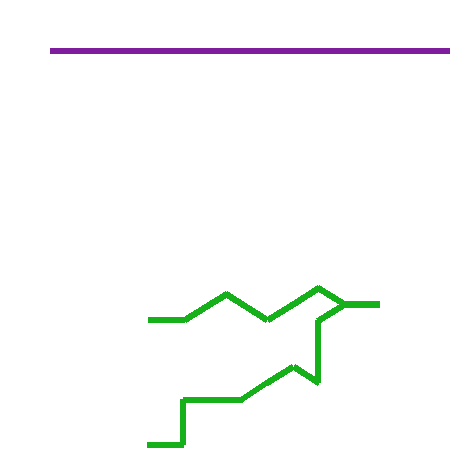

0 [184.60724863 145.73502426] [ 50. 410.] 296.5722319902761
1 [209.98543701 129.61977619] [ 84.3009802 410.       ] 307.26153776697265
2 [209.98543701  92.04475501] [127.17366971 410.        ] 328.5625155439267
3 [251.82699601  65.47520273] [183.72642537 410.        ] 351.1908649932837
4 [277.20518439  49.35995466] [218.02740556 410.        ] 365.4630649048821
5 [313.09536259  49.35995466] [258.97770761 410.        ] 364.67788921623884
6 [354.93692159  22.79040238] [315.53046327 410.        ] 389.20963688524296
7 [390.82709979  22.79040238] [356.48076532 410.        ] 388.7299103216208
8 [450.          22.79040238] [423.99639934 410.        ] 388.08176939117277
9 [450.   0.] [450. 410.] 410.0
9, Forward Stroke Error: Comparing points [209.98543701 129.61977619], [ 84.3009802 410.       ] with error 410.0
Back Stroke Error: Comparing points [209.98543701 129.61977619], [415.6990198 410.       ] with error 572.8001396647875
Forward Reference Error: Comparing points [450. 410.], [450.   0

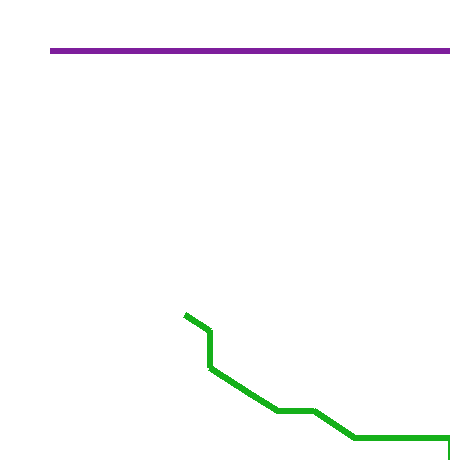

0 [334.32574249 379.44369761] [50. 50.] 435.1715497791113
1 [334.32574249 341.86867643] [ 50.         -71.54985281] 501.75293537991
2 [359.70393088 325.75342836] [ 49.87370135 215.20065118] 328.96304910047985
3 [359.70393088 263.8026917 ] [0. 0.] 446.07037341152545


IndexError: index 9 is out of bounds for axis 0 with size 4

In [43]:
alignments = alignStrokes(g, ref_g, l, ref_l)
print(alignments)

9


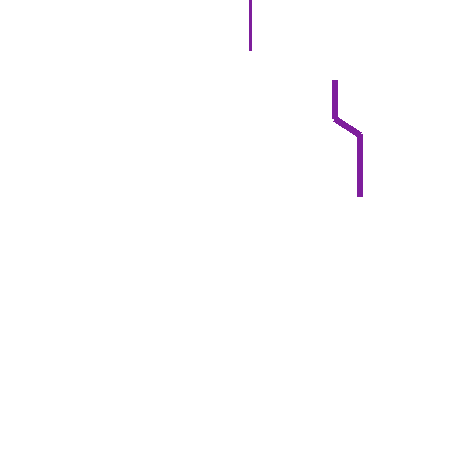

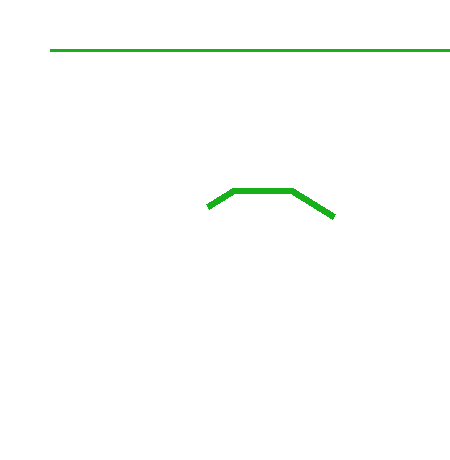

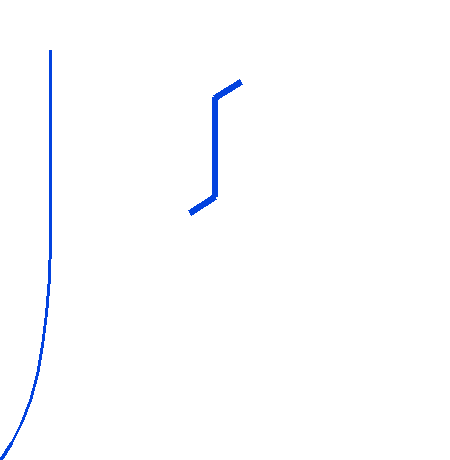

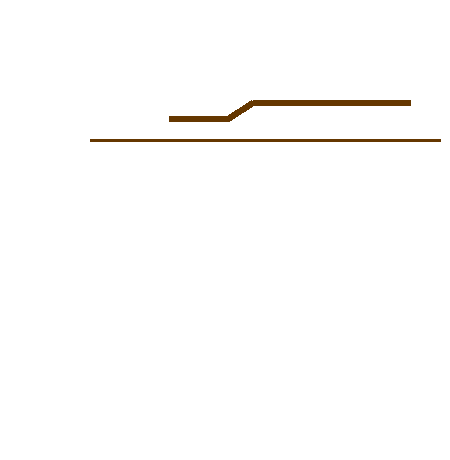

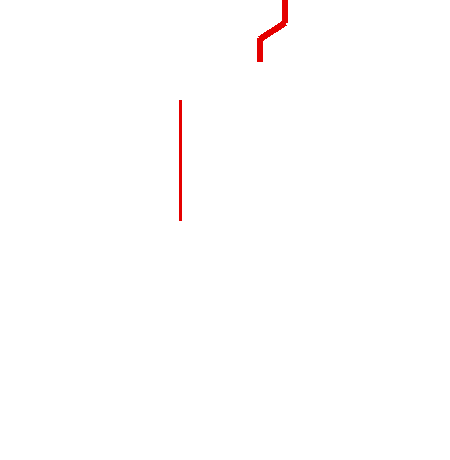

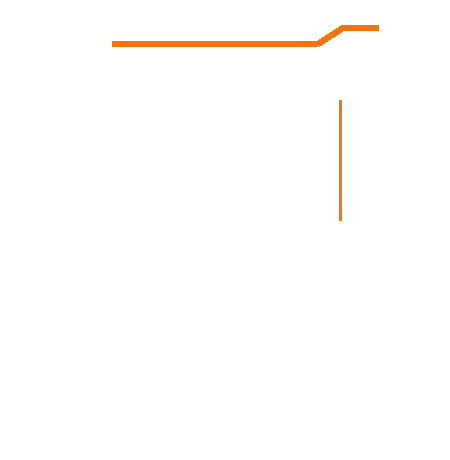

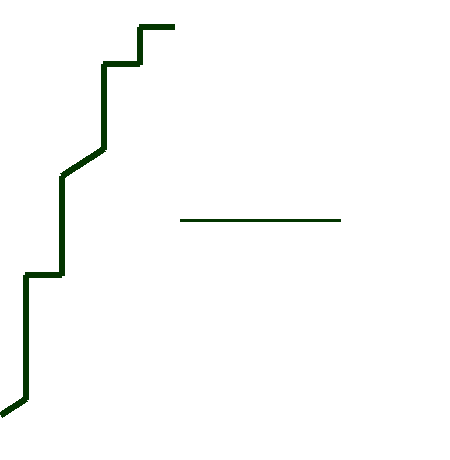

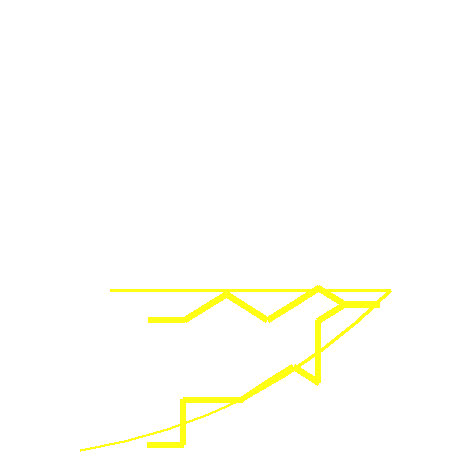

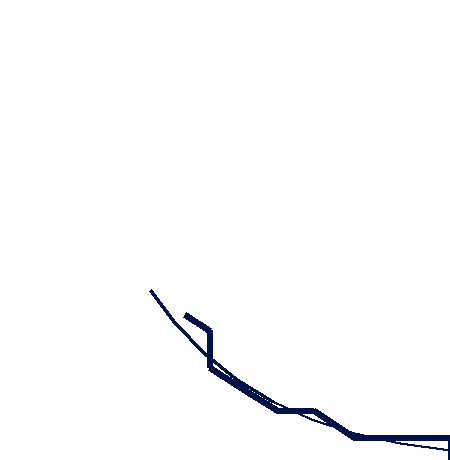

[7 4 6 8 3 2 1 0 5]


In [6]:
imgs = [Image.new(mode="RGBA", size=output_size) for _ in range(len(ref_g))]
img_full = Image.new(mode="RGBA", size=output_size)
print(len(imgs))
seed(ref_l[0][0])
xcolors = ["#7e1e9c", "#15b01a", "#0343df", "#653700", "#e50000", "#f97306", "#033500", "#ffff14", "#001146"]
color_selection = [(int(c[1:3], 16), int(c[3:5], 16), int(c[5:7], 16)) for c in xcolors]
colors = color_selection[:len(ref_l)+1]
#colors = [(randint(0, 256), randint(0, 256), randint(0, 256)) for _ in range(len(ref_l)+1)]
colors_t = [(c[0], c[1], c[2], 70) for c in colors]

priority = [7, 2, 1, 8, 3, 6, 5, 4, 0]
#alignments = [7, 6, 5, 8, 3, 1, 0, 2, 4]
#alignments = [7 4 6 8 3 2 1 0 5]
#alignments = alignments[priority]

for i in range(len(alignments)):
    draw = ImageDraw.Draw(imgs[i])
    draw_full = ImageDraw.Draw(img_full)
    for a in range(len(g[i])-1):
        x1, y1 = g[i][a]
        x2, y2 = g[i][a+1]
        y1 = -(y1-output_size[1]/2)+output_size[1]/2
        y2 = -(y2-output_size[1]/2)+output_size[1]/2
        draw.line(((x1, y1), (x2, y2)), width=6, fill=colors[i])
        draw_full.line(((x1, y1), (x2, y2)), width=6, fill=colors[i])

for i in alignments:
    draw = ImageDraw.Draw(imgs[i])
    draw_full = ImageDraw.Draw(img_full)
    for a in range(len(ref_g[i])-1):
        x1, y1 = ref_g[i][a]
        x2, y2 = ref_g[i][a+1]
        y1 = -(y1-output_size[1]/2)+output_size[1]/2
        y2 = -(y2-output_size[1]/2)+output_size[1]/2
        draw.line(((x1, y1), (x2, y2)), width=3, fill=colors[i])
        draw_full.line(((x1, y1), (x2, y2)), width=3, fill=colors[i])
        
#display(img_full)
for p in range(len(priority)):
    display(imgs[p])
    
print(alignments)